为了得到不同位置对应的编码，Transformer 模型使用不同频率的正余弦函数如下所示：

PE(pos, 2i) = sin(
pos

10000
2i/d
) (2.1)
PE(pos, 2i + 1) = cos(
pos

10000
2i/d
) (2.2)

其中，pos 表示单词所在的位置，2i 和 2i+1 表示位置编码向量中的对应维度，d 则对应位置编码的
总维度。通过上面这种方式计算位置编码有这样几个好处：首先，正余弦函数的范围是在 [-1,+1]，
导出的位置编码与原词嵌入相加不会使得结果偏离过远而破坏原有单词的语义信息。其次，依据
三角函数的基本性质，可以得知第 pos + k 个位置的编码是第 pos 个位置的编码的线性组合，这就
意味着位置编码中蕴含着单词之间的距离信息。
使用 Pytorch 实现的位置编码参考代码如下：
**这里的i对应的应该是每一个时间步**

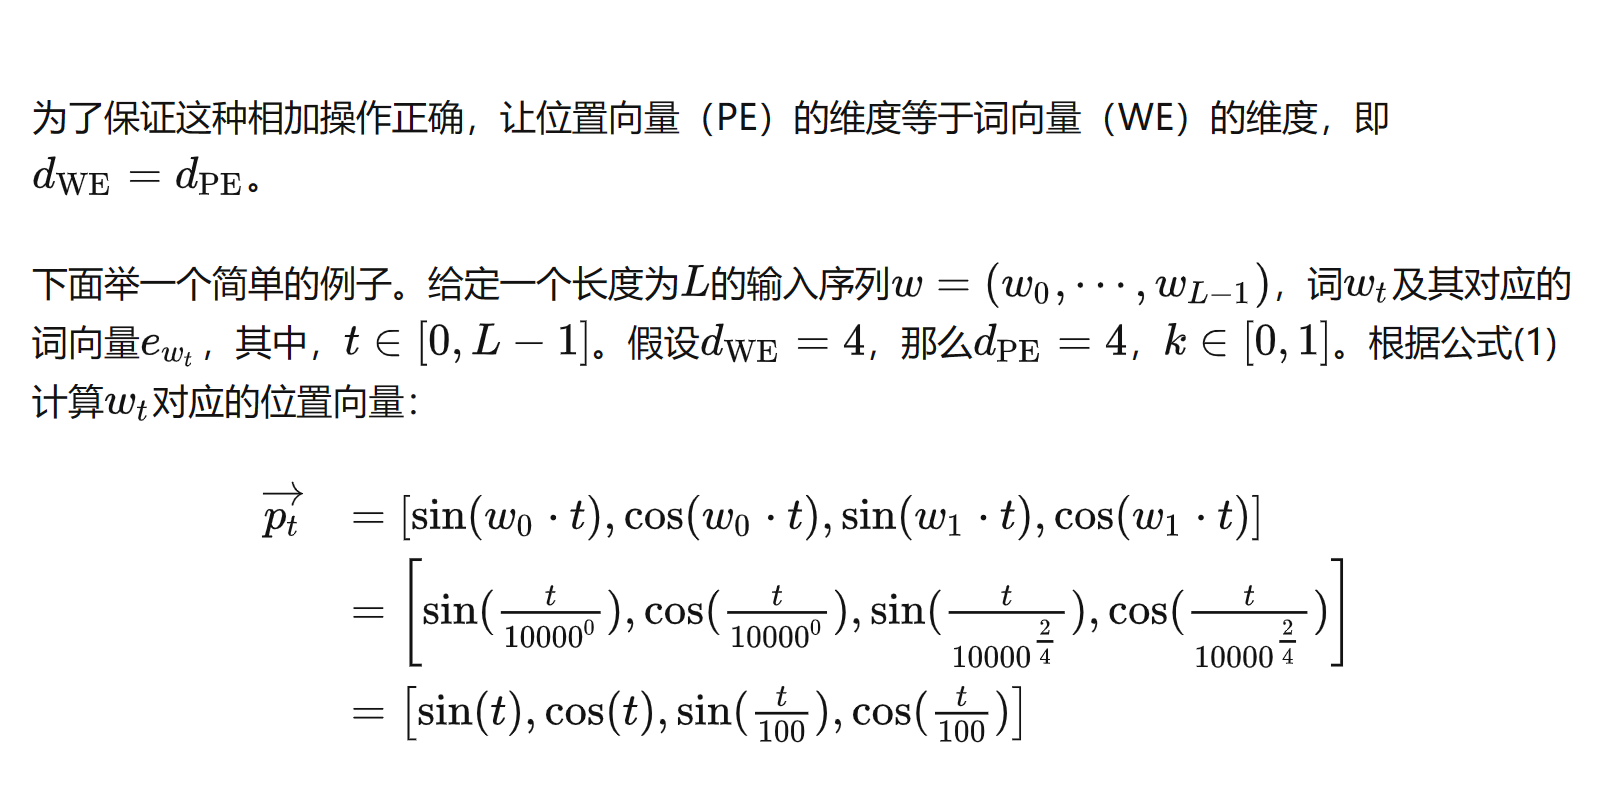

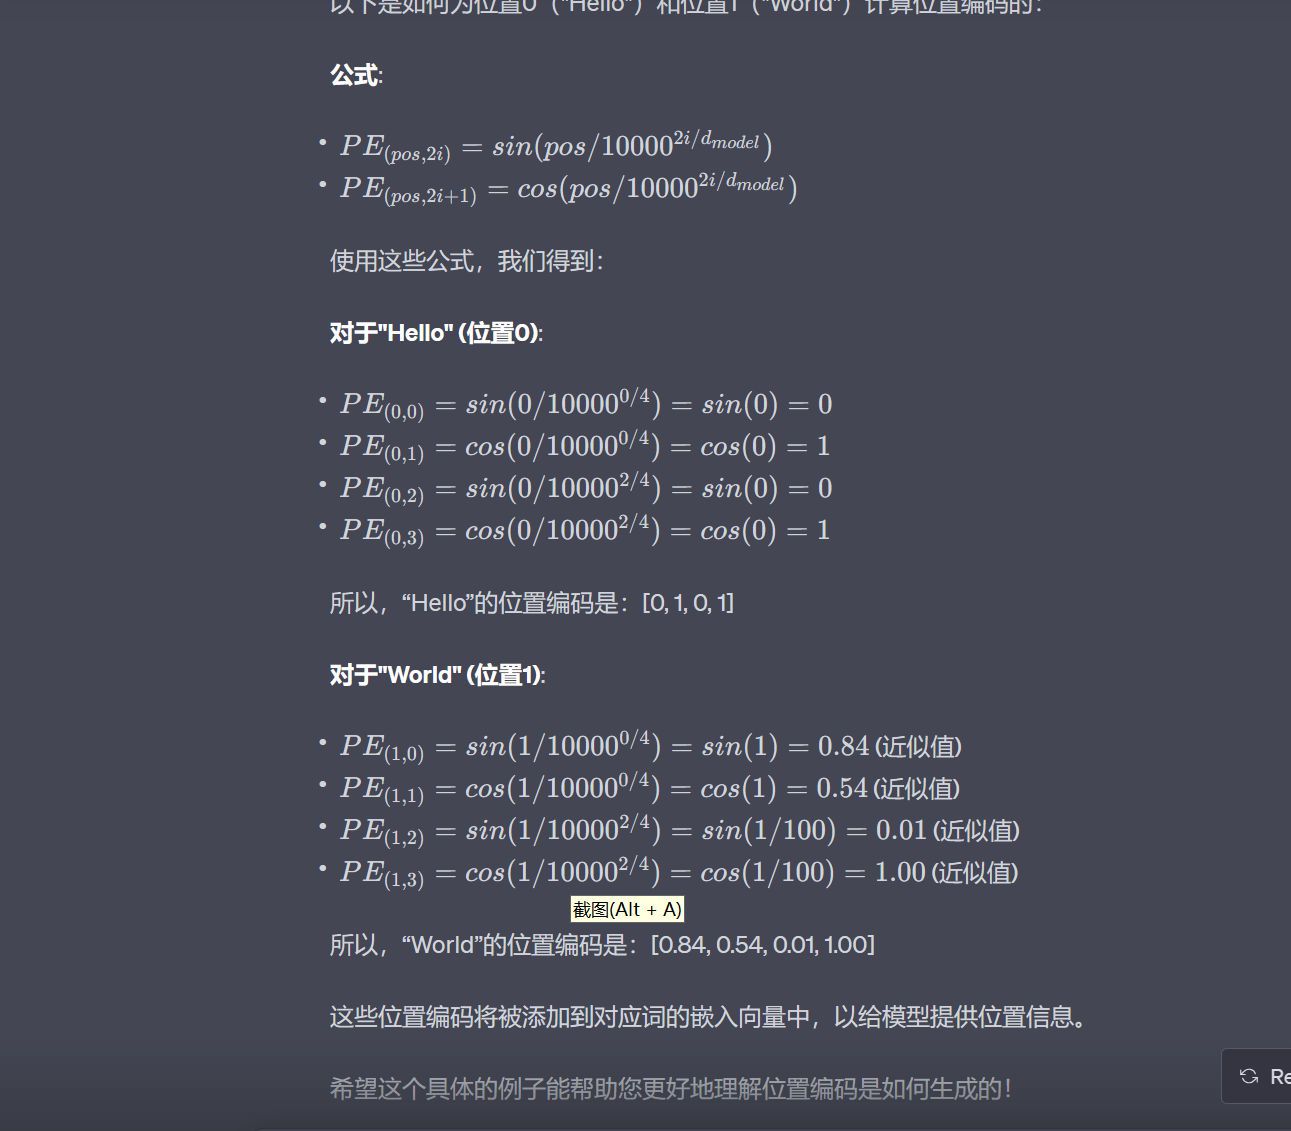

In [ ]:
import torch.nn as nn
import torch
import torch.nn.functional as F
import math
from torch.autograd import Variable


In [ ]:
class PositionalEncoder(nn.Module):
  def __init__(self,d_model,max_seq_len=80):
    super().__init__()
    self.d_model=d_model

    #根据pos和i创建一个常量PE矩阵,d_model是嵌入空间的维度，
    pe=torch.zeros(max_seq_len,d_model)
    for pos in range(max_seq_len):
      for i in range(0,d_model,2):
        pe[pos,i]=math.sin(pos/(10000**((2*i)/d_model)))
        pe[pos,i+1]=math.cos(pos/(10000**((2*(i+1))/d_model)))
    pe=pe.unsqueeze(0)
    self.register_buffer('pe',pe)

def forward(self,x):
  #使得单词嵌入表示相对大一些
  x=x*math.sqrt(self.d_model)
  #增加位置常量到单词嵌入表示中
  seq_len=x.size(1)
  x=x+Variable(self.pe[:,:seq_len],requires_grad=False).cuda()

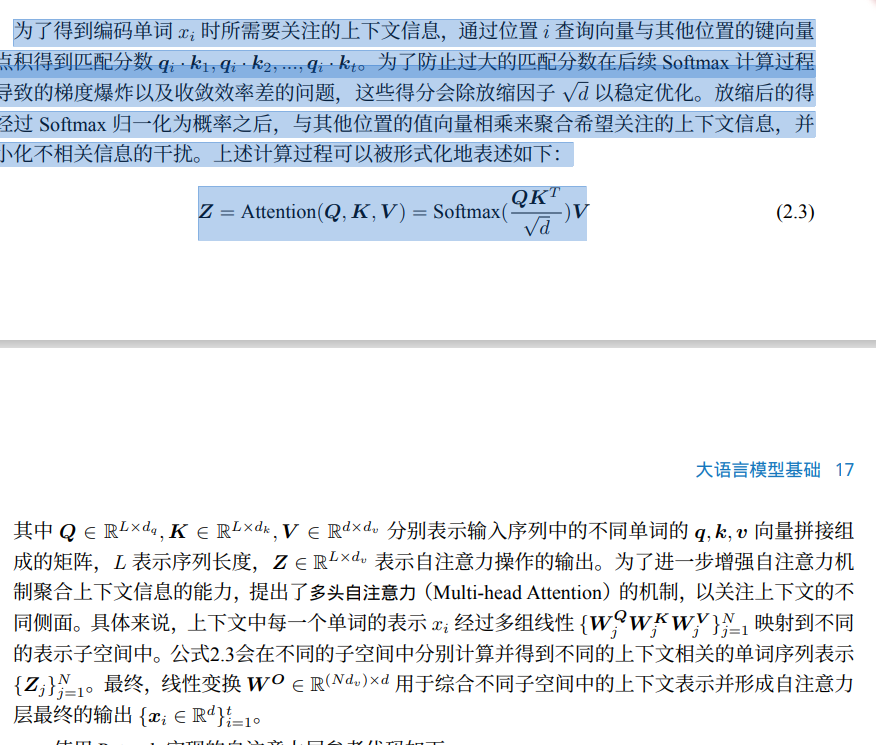

In [ ]:
class MultiHeadAttention(nn.Module):
  def __init__(self,heads,d_model,dropout=0.1):
    super().__init__()

    self.d_model=d_model
    self.d_k=d_model//heads
    self.h=heads

    self.q_linear=nn.Linear(d_model,d_model)
    self.v_linear=nn.Linear(d_model,d_model)
    self.k_linear=nn.Linear(d_model,d_model)
    self.out=nn.Linear(d_model,d_model)

  def attention(q,k,v,d_k,mask=None,dropout=None):
    scores=torch.matmul(q,k.transpose(-2,-1))/math.sqrt(d_k)
    #掩盖掉那些为了填补长度增加的单元，使其通过softmax计算后为0
    if mask is not None:
      mask=mask.unsqueeze(1)
      scores=scores.masked_fill(mask==0,-1e9)
    scores=F.softmax(scores,dim=-1)
    if dropout is not None:
      scores=dropout(scores)
    output=torch.matmul(scores,v)
    return output
  def forward(self,q,k,v,mask=None):
    bs=q.size(0)

    #进行线性操作划分为h个头
    k=self.k_linear(k).view(bs,-1,self.h,self.d_k)
    q=self.q_linear(q).view(bs,-1,self.h,self.d_k)
    v=self.v_linear(v).view(bs,-1,self.h,self.d_k)
    #矩阵转置
    k=k.transpose(1,2)
    q=q.transpose(1,2)
    v=v.transpose(1,2)
    #计算attention
    scores=self.attention(q,k,v,self.d_k,mask,self.dropout)
    concat=scores.transpose(1,2).contiguous().view(bs,-1,self.d_model)

    output=self.out(concat)

    return output

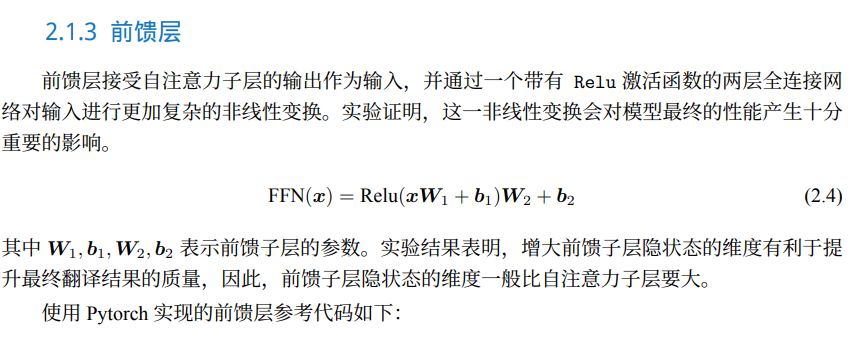

In [ ]:

class FeedForward(nn.Module):
  def __init__(self,d_model,d_ff=2048,dropout=0.1):
    super().__init__()

    #d_ff默认设置为2048
    self.linear_1=nn.Linear(d_model,d_ff)
    self.dropout=nn.Dropout(dropout)
    self.linear_2=nn.Linear(d_ff,d_model)
  def forward(self,x):
    x=self.dropout(F.relu(self.linear_1(x)))
    x=self.linear_2(x)


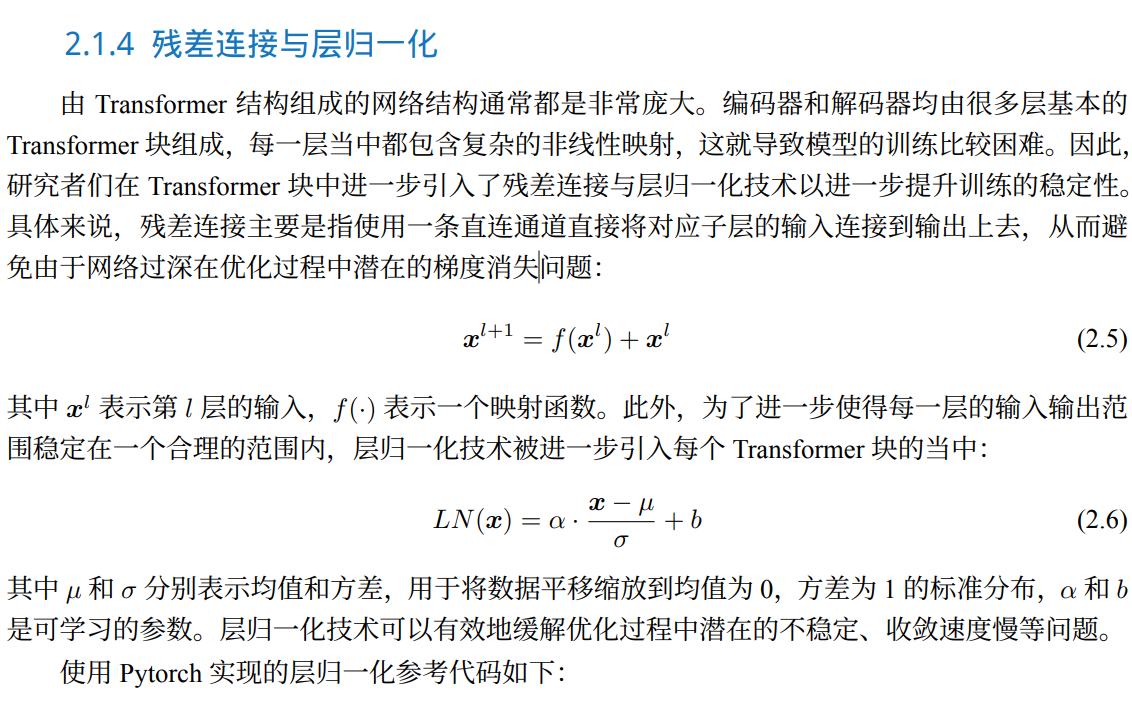

In [ ]:
class NormLayer(nn.Module):
  def __init__(self,d_model,eps=1e-6):
    super().__init__()

    self.size=d_model

    self.alpha=nn.Parameter(torch.ones(self.size))
    self.bias=nn.Parameter(torch.zeros(self.size))

    self.eps=eps  #平滑，保证分母不为0

  def forward(self,x):
    norm=self.alpha*(x-x.mean(dim=-1,keepdim=True))/ (x.std(dim=-1, keepdim=True) + self.eps) + self.bias
    return norm



2.1.5 编码器和解码器结构
基于上述模块，根据图2.1所给出的网络架构，编码器端可以较为容易实现。相比于编码器端，
解码器端要更复杂一些。具体来说，解码器的每个 Transformer 块的第一个自注意力子层额外增加了注意力掩码，

对应图中的掩码多头注意力（Masked Multi-Head Attention）部分。这主要是因为在
翻译的过程中，编码器端主要用于编码源语言序列的信息，而这个序列是完全已知的，因而编码
器仅需要考虑如何融合上下文语义信息即可。而解码端则负责生成目标语言序列，这一生成过程
是自回归的，即对于每一个单词的生成过程，仅有当前单词之前的目标语言序列是可以被观测的，
因此这一额外增加的掩码是用来掩盖后续的文本信息，以防模型在训练阶段直接看到后续的文本 **加粗文字** *斜体文本*
序列进而无法得到有效地训练。 ***加粗文字***


此外，解码器端还额外增加了一个多头注意力（Multi-Head Attention）模块，使用交叉注意
力（Cross-attention）方法，同时接收来自编码器端的输出以及当前 Transformer 块的前一个掩码注
意力层的输出。查询是通过解码器前一层的输出进行投影的，而键和值是使用编码器的输出进行
投影的。它的作用是在翻译的过程当中，为了生成合理的目标语言序列需要观测待翻译的源语言
序列是什么。基于上述的编码器和解码器结构，待翻译的源语言文本，首先经过编码器端的每个

Transformer 块对其上下文语义的层层抽象，最终输出每一个源语言单词上下文相关的表示。解码
器端以自回归的方式生成目标语言文本，即在每个时间步 t，根据编码器端输出的源语言文本表
示，以及前 t − 1 个时刻生成的目标语言文本，生成当前时刻的目标语言单词。


In [ ]:
class EncoderLayer(nn.Module):

  def __init__(self, d_model, heads, dropout=0.1):

    super().__init__()

    self.norm_1 = Norm(d_model)

    self.norm_2 = Norm(d_model)

    self.attn = MultiHeadAttention(heads, d_model, dropout=dropout)

    self.ff = FeedForward(d_model, dropout=dropout)

    self.dropout_1 = nn.Dropout(dropout)

    self.dropout_2 = nn.Dropout(dropout)

  def forward(self, x, mask):
    x2 = self.norm_1(x)
    x = x + self.dropout_1(self.attn(x2,x2,x2,mask))
    x2 = self.norm_2(x)
    x = x + self.dropout_2(self.ff(x2))

    return x

class Encoder(nn.Module):

  def __init__(self, vocab_size, d_model, N, heads, dropout):

    super().__init__()

    self.N = N

    self.embed = Embedder(vocab_size, d_model)

    self.pe = PositionalEncoder(d_model, dropout=dropout)

    self.layers = get_clones(EncoderLayer(d_model, heads, dropout), N)

    self.norm = Norm(d_model)

  def forward(self, src, mask):
    x = self.embed(src)
    x = self.pe(x)

    for i in range(self.N):
      x = self.layers[i](x, mask)

    return self.norm(x)


2.2.3 基于 HuggingFace 的预训练语言模型实践

HuggingFace 是一个开源自然语言处理软件库。其的目标是通过提供一套全面的工具、库和模
型，使得自然语言处理技术对开发人员和研究人员更加易于使用。HuggingFace 最著名的贡献之一
是 Transformer 库，基于此研究人员可以快速部署训练好的模型以及实现新的网络结构。除此之外，

HuggingFace 还提供了 Dataset 库，可以非常方便地下载自然语言处理研究中最常使用的基准数据
集。本节中，将以构建 BERT 模型为例，介绍基于 Huggingface 的 BERT 模型构建和使用方法。

1. 数据集合准备

常见的用于预训练语言模型的大规模数据集都可以在 Dataset 库中直接下载并加载。例如，如
果使用维基百科的英文语料集合，可以直接通过如下代码完成数据获取：


In [ ]:
!pip install datasets
from datasets import concatenate_datasets, load_dataset

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.6/519.6 kB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 12.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 16.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 13.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 24.1 MB/s eta 0:00:00


In [ ]:
bookcorpus=load_dataset("bookcorpus",split='train')
wiki=load_dataset("wikipedia","20230601.en",split="train")
#仅保留'text'列
wiki=wiki.remove_columns([col for col in wiki.column_names if col!="text"])
dataset = concatenate_datasets([bookcorpus, wiki])
#将数据集合切分为90%用于训练，10%用于测试
d=dataset.train_test_split(test_size=0.1)

Generating train split:   0%|          | 0/74004228 [00:00<?, ? examples/s]

KeyboardInterrupt: ignored

**下来将训练和测试数据分别保存在本地文件中**

In [ ]:
def dataset_to_text(dataset, output_filename="data.txt"):

"""Utility function to save dataset text to disk,
useful for using the texts to train the tokenizer
(as the tokenizer accepts files)"""
  with open(output_filename, "w") as f:

    for t in dataset["text"]:

      print(t, file=f)

  # save the training set to train.txt

  dataset_to_text(d["train"], "train.txt")

  # save the testing set to test.txt

  dataset_to_text(d["test"], "test.txt")


2.3.1 LLaMA 的模型结构

文献 [37] 介绍了 LLaMA 所采用的 Transformer 结构和细节，与在本章 2.2 节所介绍的 Transformer
架构不同的地方包括采用了前置层归一化（Pre-normalization）并使用 RMSNorm 归一化函数
（Normalizing Function）、激活函数更换为 SwiGLU，并使用了旋转位置嵌入（RoP），整体 Transformer

架构与 GPT-2 类似，如图2.4所示。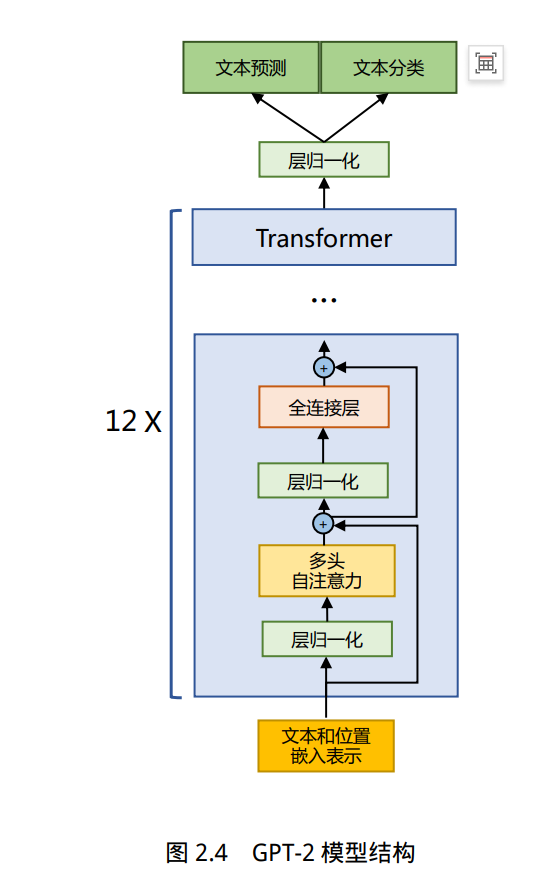

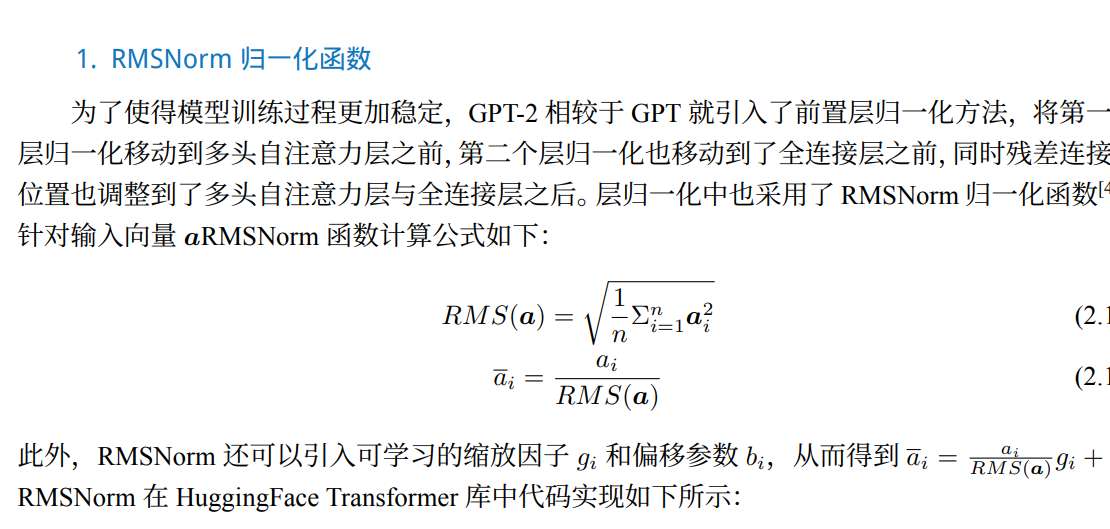

In [ ]:
class LlamaRMSNorm(nn.Module):
  def __init__(self,hidden_size,eps=1e-6):
    """
    LlamaRMSNorm is equivalent to T5LayerNorm
    """
    super().__init__()
    self.weight=nn.Parameter(torch.onse(hidden_size))
    self.variance_epsilon=eps
  def forward(self, hidden_states):
    input_dtype = hidden_states.dtype
    variance = hidden_states.to(torch.float32).pow(2).mean(-1, keepdim=True)
    hidden_states = hidden_states * torch.rsqrt(variance + self.variance_epsilon)

    # weight 是末尾乘的可训练参数, 即 g_i

    return (self.weight * hidden_states).to(input_dtype)


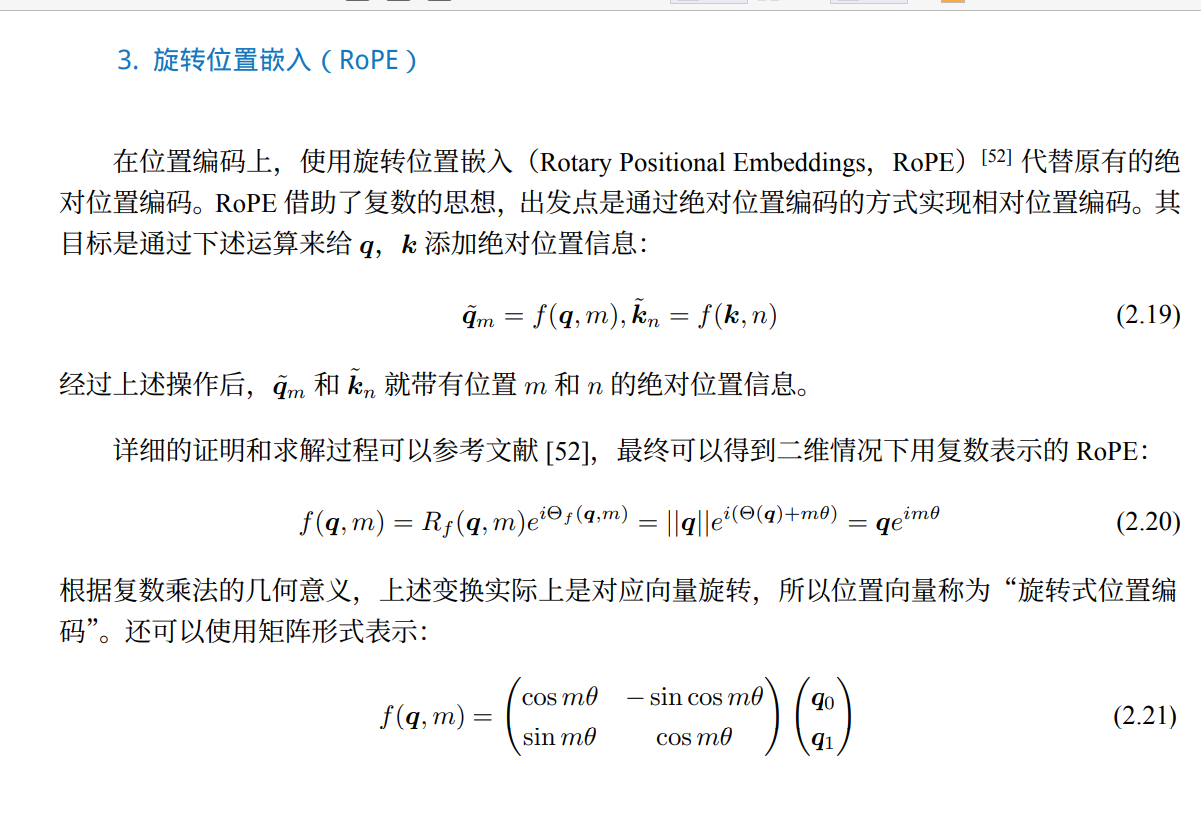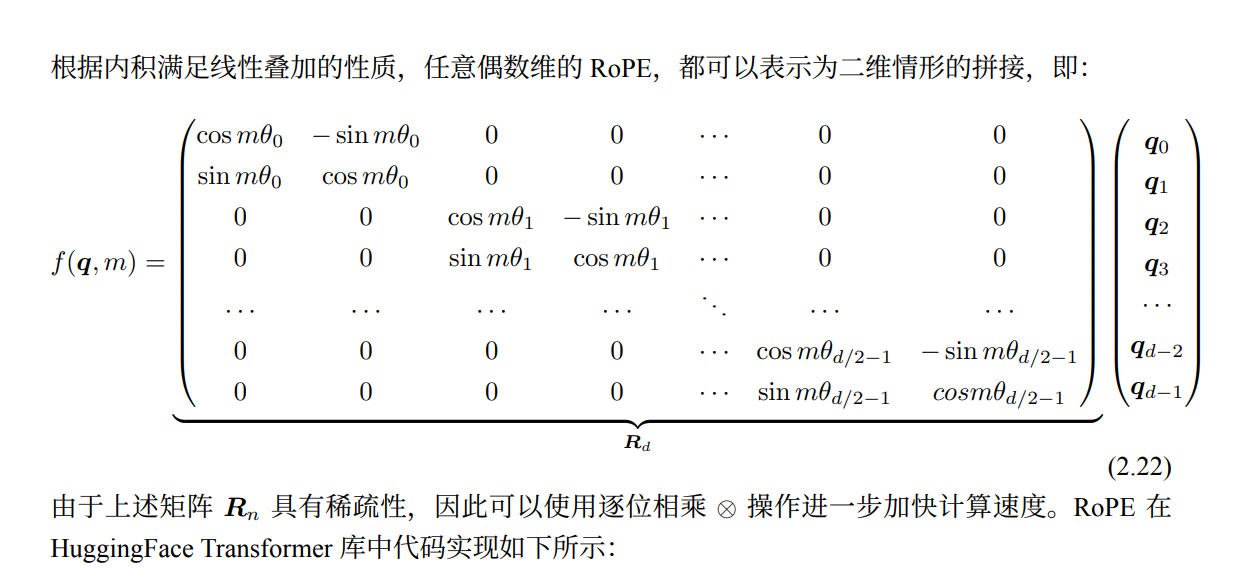

In [ ]:
class LlamaRotaryEmbedding(torch.nn.Module):

  def __init__(self, dim, max_position_embeddings=2048, base=10000, device=None):

    super().__init__()
    inv_freq = 1.0 / (base ** (torch.arange(0, dim, 2).float().to(device) / dim))

    self.register_buffer("inv_freq", inv_freq)

    # Build here to make `torch.jit.trace` work.

    self.max_seq_len_cached = max_position_embeddings
    t = torch.arange(self.max_seq_len_cached, device=self.inv_freq.device,
    dtype=self.inv_freq.dtype)
    freqs = torch.einsum("i,j->ij", t, self.inv_freq)

    # Different from paper, but it uses a different permutation
    # in order to obtain the same calculation

    emb = torch.cat((freqs, freqs), dim=-1)
    dtype = torch.get_default_dtype()

    self.register_buffer("cos_cached", emb.cos()[None, None, :, :].to(dtype), persistent=False)

    self.register_buffer("sin_cached", emb.sin()[None, None, :, :].to(dtype), persistent=False)

  def forward(self, x, seq_len=None):

  # x: [bs, num_attention_heads, seq_len, head_size]
  # This `if` block is unlikely to be run after we build sin/cos in `__init__`.
  # Keep the logic here just in case.

    if seq_len > self.max_seq_len_cached:

      self.max_seq_len_cached = seq_len
      t = torch.arange(self.max_seq_len_cached, device=x.device, dtype=self.inv_freq.dtype)
      freqs = torch.einsum("i,j->ij", t, self.inv_freq)

      # Different from paper, but it uses a different permutation
      # in order to obtain the same calculation

      emb = torch.cat((freqs, freqs), dim=-1).to(x.device)

      self.register_buffer("cos_cached", emb.cos()[None, None, :, :].to(x.dtype),
      persistent=False)

      self.register_buffer("sin_cached", emb.sin()[None, None, :, :].to(x.dtype),
      persistent=False)
      return (

      self.cos_cached[:, :, :seq_len, ...].to(dtype=x.dtype),

      self.sin_cached[:, :, :seq_len, ...].to(dtype=x.dtype),
      )
  def rotate_half(x):

    """Rotates half the hidden dims of the input."""

    x1 = x[..., : x.shape[-1] // 2]
    x2 = x[..., x.shape[-1] // 2 :]

    return torch.cat((-x2, x1), dim=-1)

    def apply_rotary_pos_emb(q, k, cos, sin, position_ids):

      # The first two dimensions of cos and sin are always 1, so we can `squeeze` them.

      cos = cos.squeeze(1).squeeze(0) # [seq_len, dim]

      sin = sin.squeeze(1).squeeze(0) # [seq_len, dim]

      cos = cos[position_ids].unsqueeze(1) # [bs, 1, seq_len, dim]

      sin = sin[position_ids].unsqueeze(1) # [bs, 1, seq_len, dim]

      q_embed = (q * cos) + (rotate_half(q) * sin)
      k_embed = (k * cos) + (rotate_half(k) * sin)

      return q_embed, k_embed


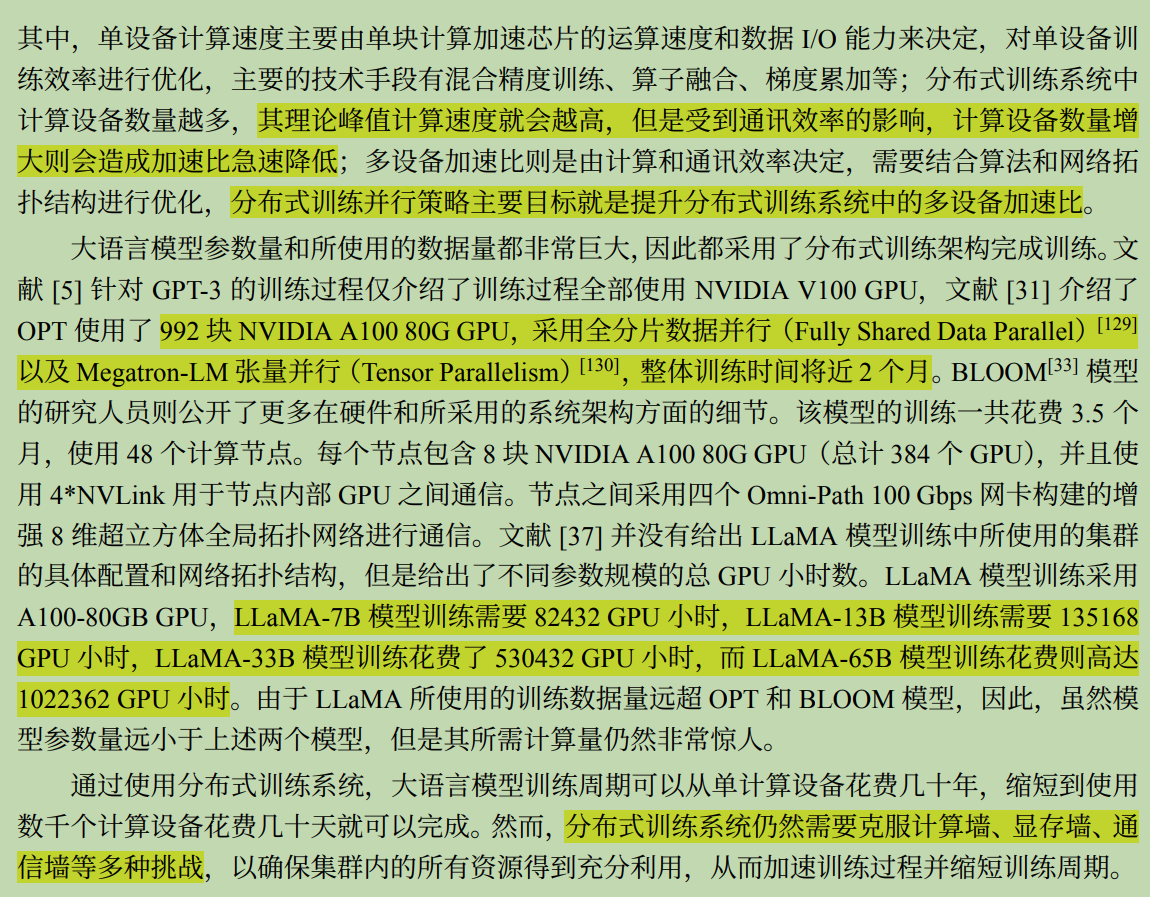

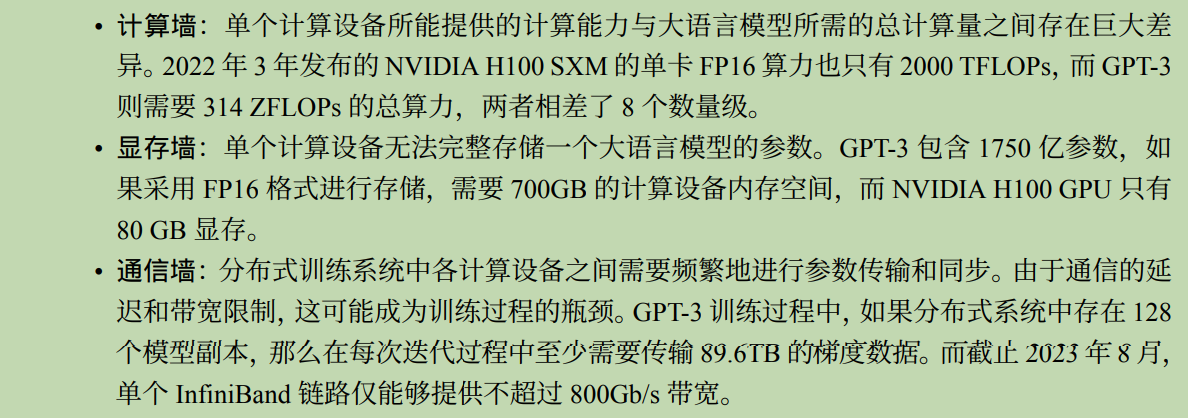

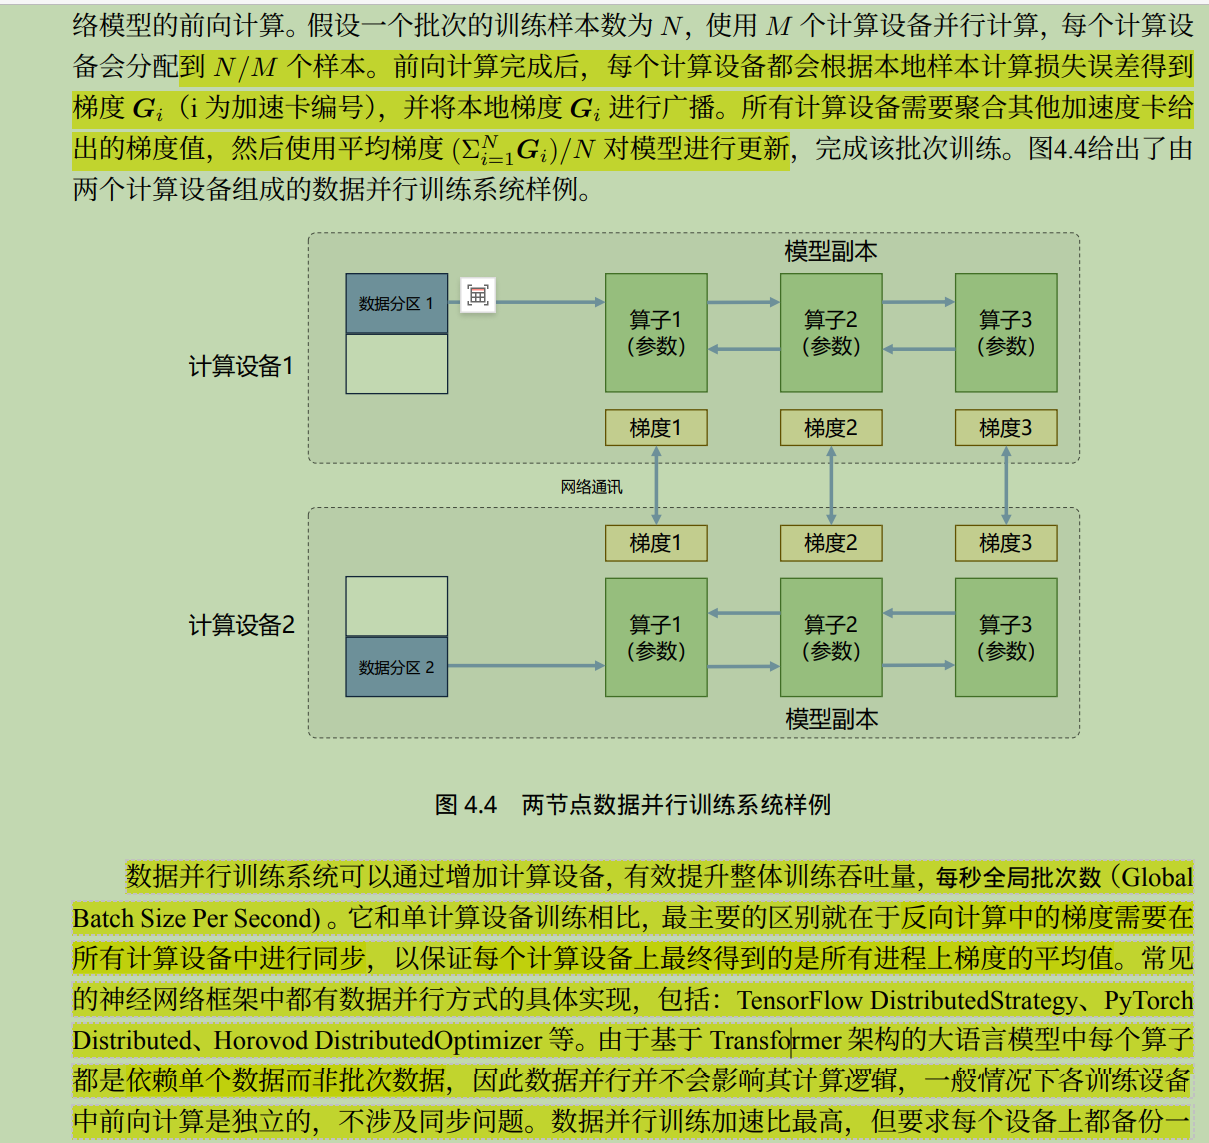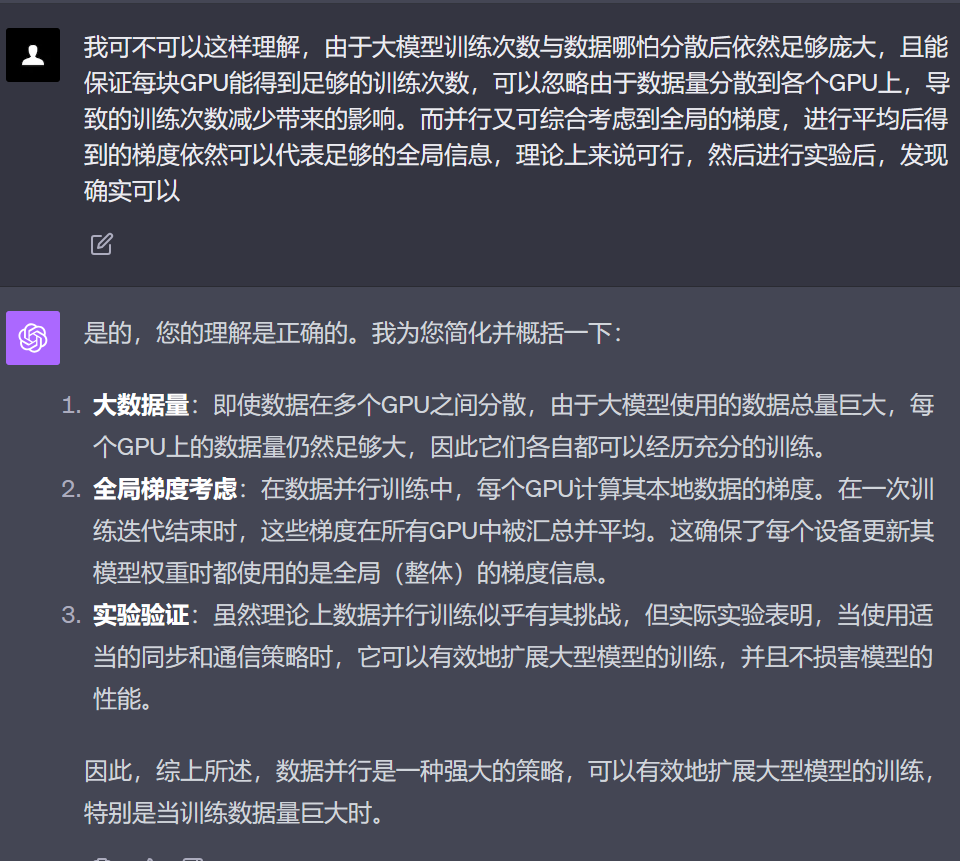

.4.2 LLaMA 分布式训练实践

LLaMA 模型是目前最流行和性能最强大的开源模型之一，基于 LLaMA 所构造的模型生态
可以覆盖绝大部分模型使用场景。在设置完必要的数据和环境配置后，本节将逐步演示如何使用

DeepSpeed 框架训练 LLaMA 模型。

Deepspeed 可以很好的兼容 PyThorch 和 CUDA 的大多数版本，其安装过程通常无需指定特殊
配置选项，可以直接通过 pip 命令完成。

In [ ]:
!pip install deepspeed
!pip install transformers
!pip install utils

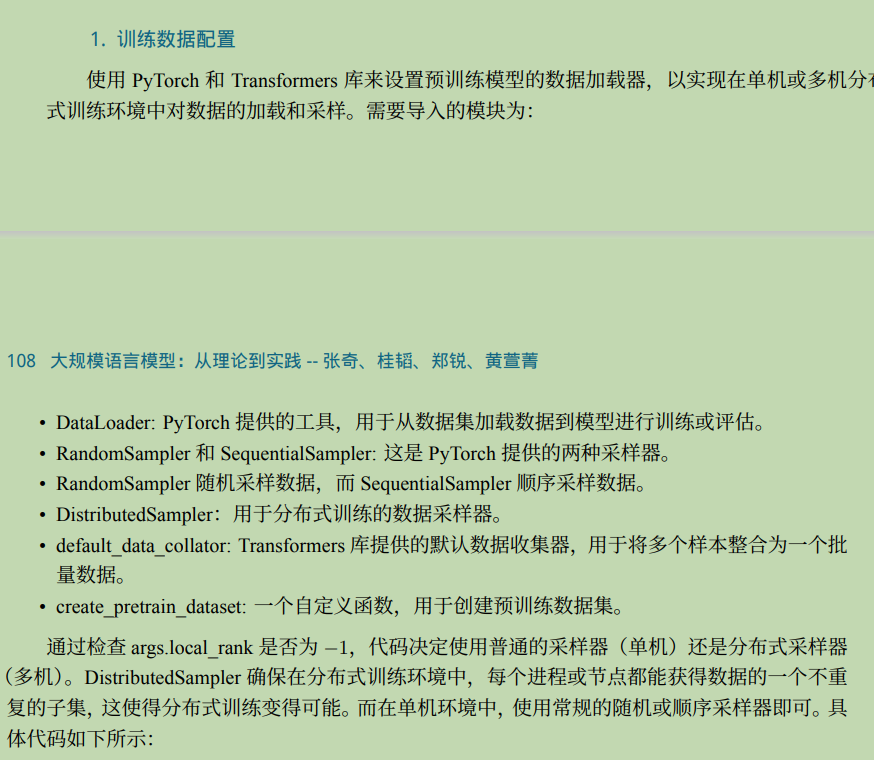

In [ ]:
from torch.utils.data import DataLoader,RandomSampler,SequentialSampler
from torch.utils.data.distributed import DistributedSampler
from transformers import default_data_collator

你提到的 args 通常是一个对象，它包含了一系列从命令行接收的参数。这种做法经常出现在深度学习和其他编程任务中，因为它允许用户在命令行中轻松地修改和指定不同的参数，而不需要直接修改代码。

通常，这样的 args 对象是通过使用像 argparse 这样的Python库创建的。argparse 允许你轻松定义和处理命令行参数。

以下是一个简单的例子来解释这种用法

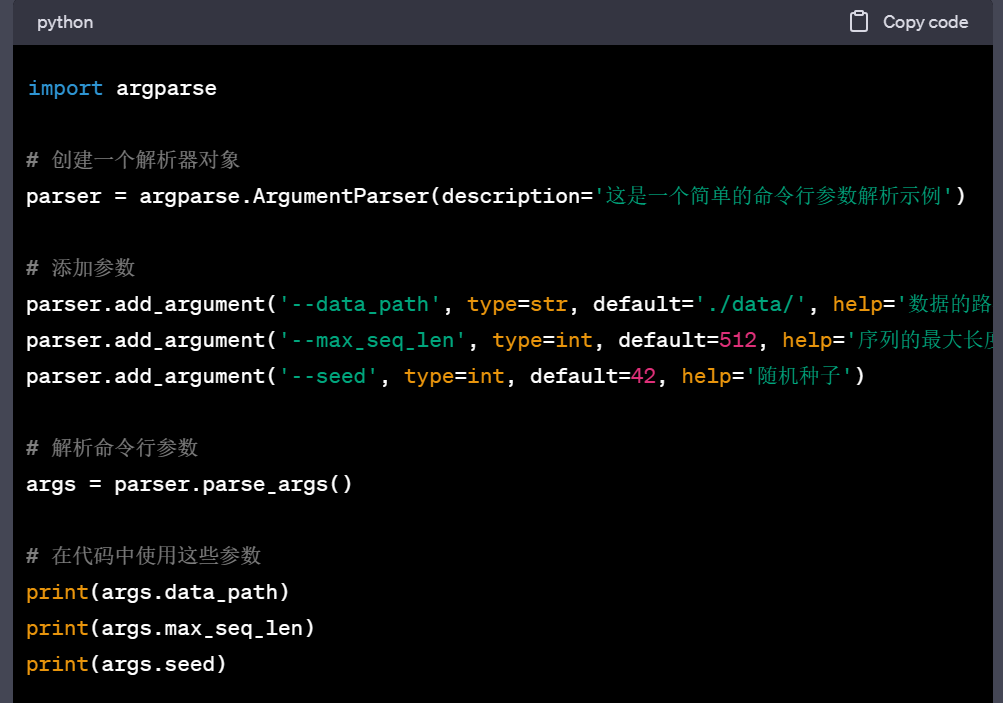

In [ ]:
import argparse

# 创建一个解析器对象
parser = argparse.ArgumentParser(description='这是一个简单的命令行参数解析示例')

# 添加参数
parser.add_argument('--data_path', type=str, default='./data/', help='数据的路径')
parser.add_argument('--max_seq_len', type=int, default=512, help='序列的最大长度')
parser.add_argument('--seed', type=int, default=42, help='随机种子')

# 解析命令行参数
args = parser.parse_args()

# 在代码中使用这些参数
print(args.data_path)
print(args.max_seq_len)
print(args.seed)


usage: colab_kernel_launcher.py [-h] [--local_rank LOCAL_RANK] --data_path
                                DATA_PATH
colab_kernel_launcher.py: error: the following arguments are required: --data_path


SystemExit: ignored

In [ ]:
python your_script_name.py --data_path ./my_data/ --max_seq_len 256


SyntaxError: ignored

2. 模型载入

使用 Transformers 库加载和配置 LLaMA 模型及其相关的分词器。在从 transformers 库中导入

LLaMA 模型、相应的分词器和模型配置后，使用 from_pretrained 方法来加载预训练的 LLaMA 模
型、分词器和配置。为了确保分词器可以处理各种文本长度，还需要进行了填充设置。如果分词
器还没有指定填充符号，将其设置为 [PAD]，并确定填充行为发生在句子的右侧。此外，为了保证
模型能够正确地处理句子结束和填充，还为模型配置设置了结束符号和填充符号的 ID。最后，为
了优化模型在硬件上的性能，还需要调整了模型的词汇表嵌入大小，使其成为 8 的倍数。通过这
些步骤，可以成功地加载并配置了 LLaMA 模型，为后续的训练任务做好了准备。具体代码如下

In [ ]:
from transformers import LlamaTokenizer, LlamaConfig, LlamaForCausalLM
import math


In [ ]:
tokenizer=LlamaTokenizer.from_pretrained(
    model_name_or_path,fast_tokenizer=True)
if tokenizer.pad_token is None:
  # assert tokenizer.eos_token is not None
# tokenizer.add_special_tokens({'pad_token': tokenizer.eos_token})
  tokenizer.add_special_tokens({'pad_token': '[PAD]'})
  tokenizer.padding_side = 'right'
model_config = LlamaConfig.from_pretrained(model_name_or_path)
model = LlamaForCausalLM.from_pretrained(model_name_or_path, config=model_config)
model.config.end_token_id = tokenizer.eos_token_id
model.config.pad_token_id = model.config.eos_token_id
model.resize_token_embeddings(int(

8 *

math.ceil(len(tokenizer) / 8.0))) # make the vocab size multiple of 8


ImportError: ignored

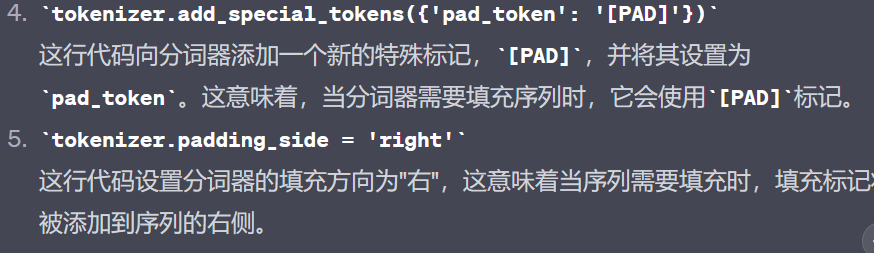

In [ ]:
!pip install sentencepiece


In [ ]:
import sentencepiece

# 如果没有报错，表示库已成功导入
print("SentencePiece库已成功导入")


SentencePiece库已成功导入


In [ ]:
tokenizer=LlamaTokenizer.from_pretrained(
    model_name_or_path,fast_tokenizer=True)
if tokenizer.pad_token is None:
  # assert tokenizer.eos_token is not None
# tokenizer.add_special_tokens({'pad_token': tokenizer.eos_token})
  tokenizer.add_special_tokens({'pad_token': '[PAD]'})
  tokenizer.padding_side = 'right'
model_config = LlamaConfig.from_pretrained(model_name_or_path)
model = LlamaForCausalLM.from_pretrained(model_name_or_path, config=model_config)
model.config.end_token_id = tokenizer.eos_token_id
model.config.pad_token_id = model.config.eos_token_id
model.resize_token_embeddings(int(

8 *

math.ceil(len(tokenizer) / 8.0))) # make the vocab size multiple of 8

ImportError: ignored

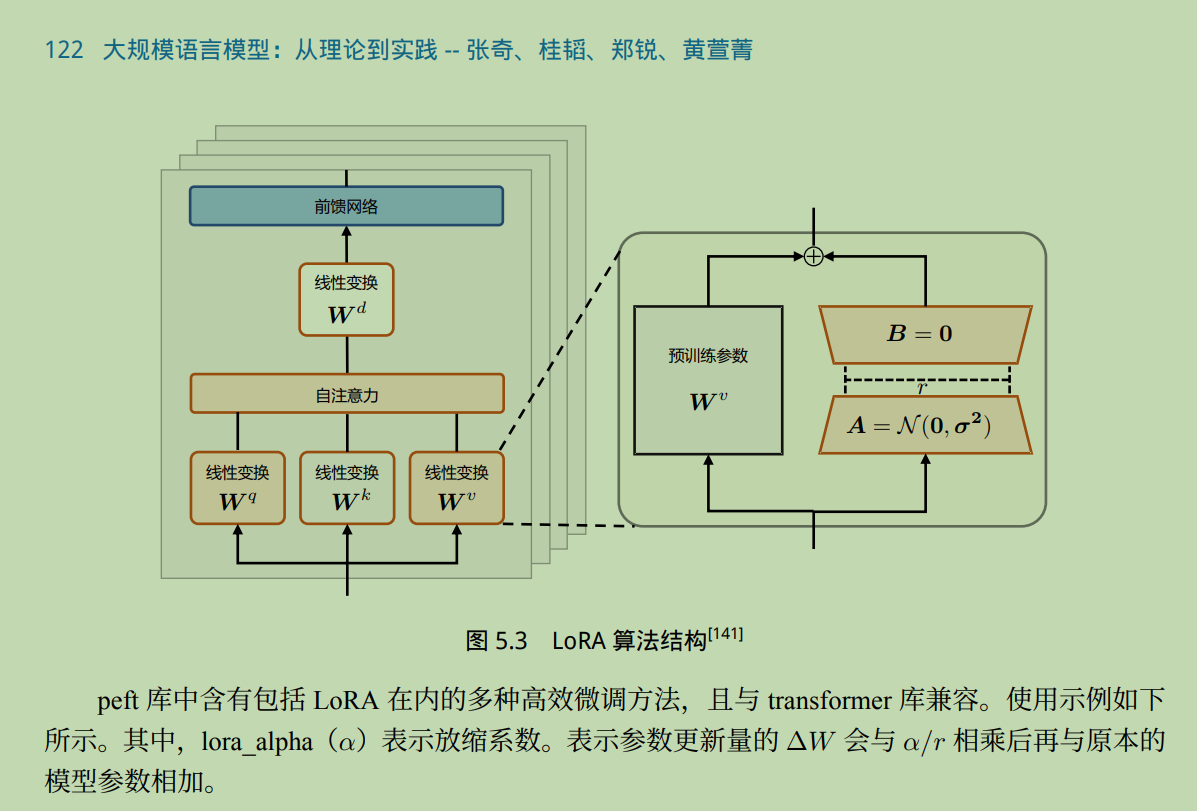

In [ ]:
!pip install peft

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.6/85.6 kB 1.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 258.1/258.1 kB 8.2 MB/s eta 0:00:00


In [ ]:
from transformers import AutoModelForSeq2SeqLM
from peft import get_peft_config,get_peft_model,LoraConfig,TaskType
model_name_or_path="bigscience/mt0-large"
tokenizer_name_or_path="bigscience/mt0-large"

peft_config = LoraConfig(
  task_type=TaskType.SEQ_2_SEQ_LM, inference_mode=False, r=8, lora_alpha=32, lora_dropout=0.1

)
model=AutoModelForSeq2SeqLM.from_pretrained(model_name_or_path)
model=get_peft_model(model,peft_config)

In [ ]:
class LoraModel(torch.nn.Module):
  def __init__(self, model, config, adapter_name):

    super().__init__()

    self.model = model

    self.forward = self.model.forward

    self.peft_config = config

    self.add_adapter(adapter_name, self.peft_config[adapter_name])

    # transformers models have a .config attribute, whose presence is assumed later on

    if not hasattr(self, "config"):

      self.config = {"model_type": "custom"}

  def add_adapter(self, adapter_name, config=None):
    if config is not None:
      model_config = getattr(self.model, "config", {"model_type": "custom"})

      if hasattr(model_config, "to_dict"):
        model_config = model_config.to_dict()
      config = self._prepare_lora_config(config, model_config)

      self.peft_config[adapter_name] = config

    self._find_and_replace(adapter_name)

    if len(self.peft_config) > 1 and self.peft_config[adapter_name].bias != "none":
      raise ValueError(
          "LoraModel supports only 1 adapter with bias. When using multiple adapters, "
          "set bias to 'none' for all adapters."
      )

      mark_only_lora_as_trainable(self.model, self.peft_config[adapter_name].bias)

      if self.peft_config[adapter_name].inference_mode:
          _freeze_adapter(self.model, adapter_name)



LoraModel 类通过 add_adapter 方法添加 LoRA 层。该方法包括 _find_and_replace 和 _mark_
only_lora_as_trainable 两个主要函数。_mark_only_lora_as_trainable 的作用是仅将 Lora 参数设为可
训练，其余参数冻结；_find_and_replace 会根据 config 中的参数从基础模型的 named_parameters 中
找出包含指定名称的模块（默认为“q”、“v”，即注意力模块的 Q 和 V 矩阵），创建一个新的自定
义类 Linear 模块，并替换原来的。


In [ ]:
class Linear(nn.Linear, LoraLayer):
    # Lora implemented in a dense layer
    def __init__(
        self,
        adapter_name: str,
        in_features: int,
        out_features: int,
        r: int = 0,
        lora_alpha: int = 1,
        lora_dropout: float = 0.0,
        fan_in_fan_out: bool = False,
        is_target_conv_1d_layer: bool = False,
        **kwargs,
    ):
        init_lora_weights = kwargs.pop("init_lora_weights", True)
        nn.Linear.__init__(self, in_features, out_features, **kwargs)
        LoraLayer.__init__(self, in_features=in_features, out_features=out_features)

        # Freezing the pre-trained weight matrix
        self.weight.requires_grad = False

        self.fan_in_fan_out = fan_in_fan_out
        if fan_in_fan_out:
            self.weight.data = self.weight.data.T
            nn.Linear.reset_parameters(self)

        self.update_layer(adapter_name, r, lora_alpha, lora_dropout, init_lora_weights)
        self.active_adapter = adapter_name
        self.is_target_conv_1d_layer = is_target_conv_1d_layer


NameError: ignored

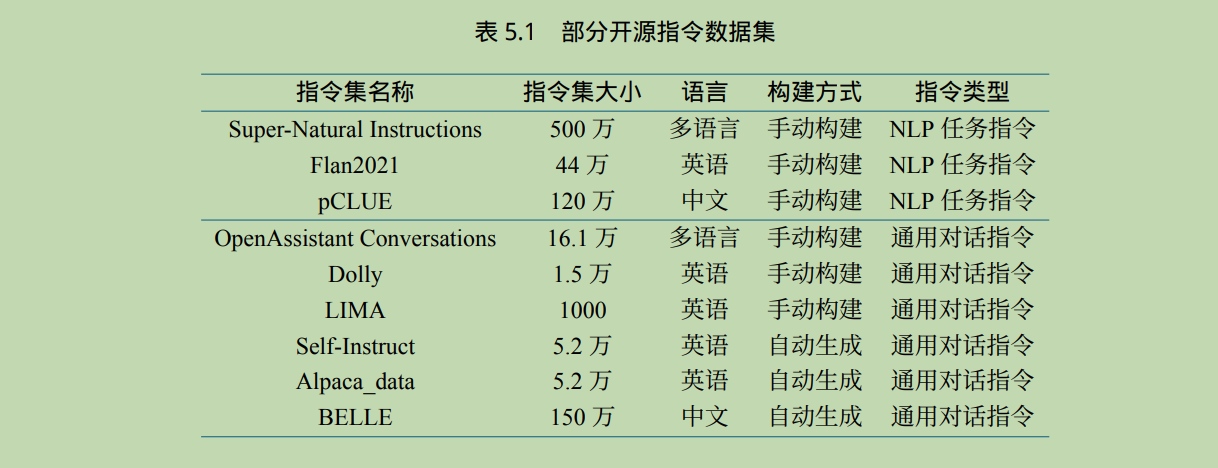

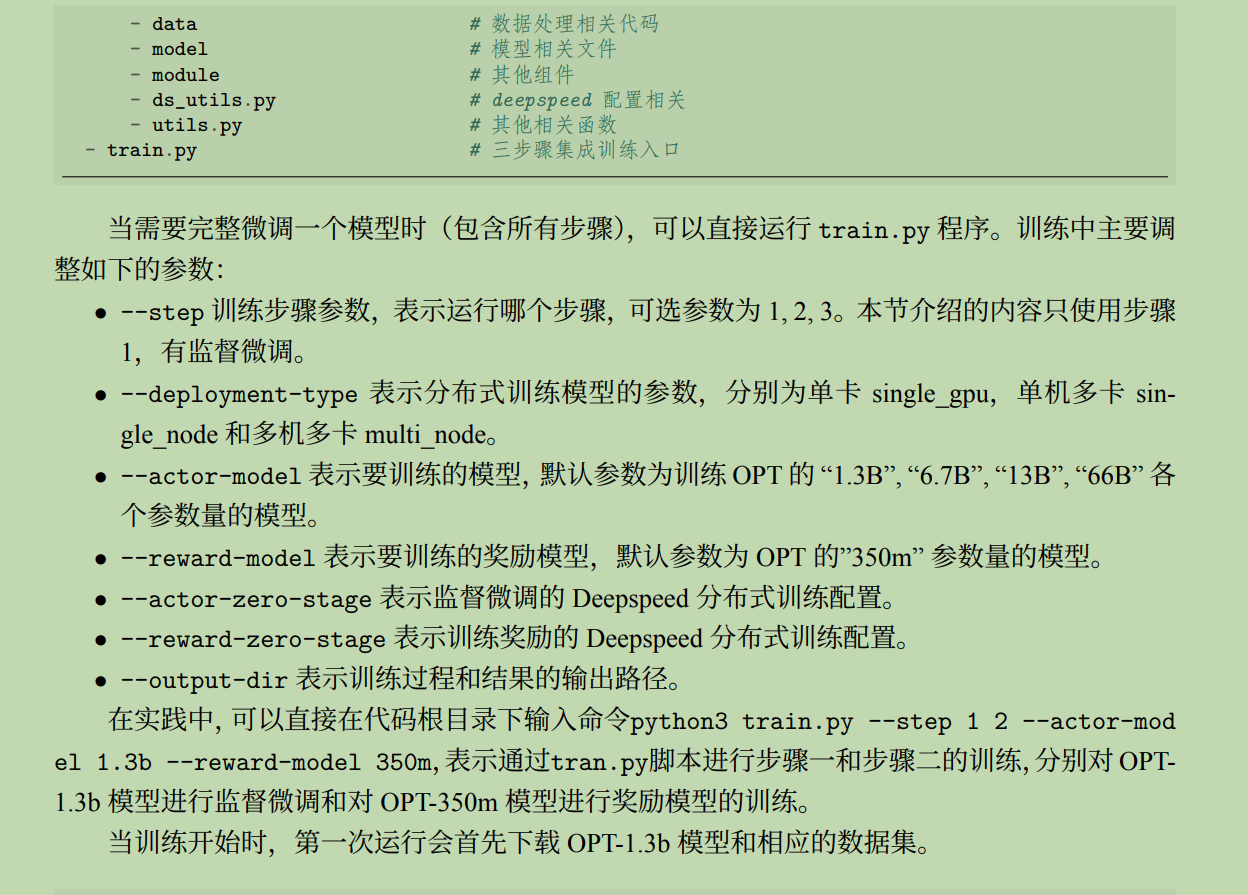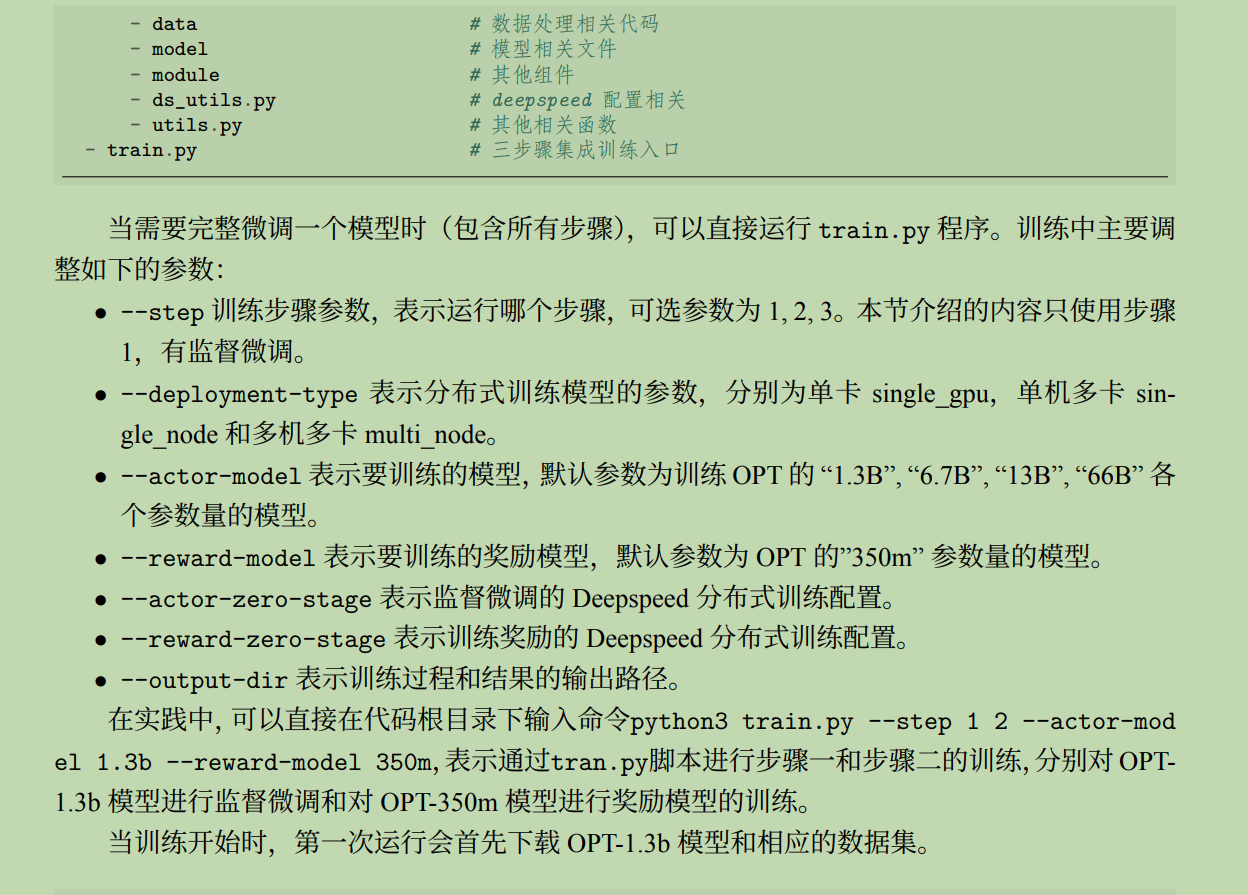